In [21]:
# This implementation of Efficient-CapsNet is adapted from the code by Akhdan Fadhila
# available at https://github.com/akhdanfadh/efficient-capsnet-pytorch. Modifications were made
# to fit the specific requirements of the MNIST digit recognition task.

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from torch.optim import lr_scheduler
from torch import optim
import seaborn as sns
from torchsummary import summary
import os

In [22]:
def squash(x, eps=10e-21):
    n = torch.norm(x, dim=-1, keepdim=True)
    return (1 - 1 / (torch.exp(n) + eps)) * (x / (n + eps))


def length(x):
    return torch.sqrt(torch.sum(x ** 2, dim=-1) + 1e-8)


def mask(x):
    """
    Mask the output of the capsule layer to select the capsule with the highest vector length.
    :param x: tensor(batch_size, num_capsules, dim_capsules) or list([tensor, mask])
    :return: tensor(batch_size, num_capsules * dim_capsules)
    """
    if isinstance(x, list):
        x, mask = x
    else:
        # Compute lengths of the capsules
        lengths = torch.sqrt(torch.sum(x**2, dim=2))
        
        # Create a one-hot encoding of the index of the max length capsule
        _, max_length_indices = lengths.max(dim=1, keepdim=True)
        mask = F.one_hot(max_length_indices, num_classes=x.size(1)).float()
        mask = mask.squeeze(1)
    
    # Apply the mask and combine the capsule dimensions
    masked = x * mask.unsqueeze(2)
    return masked.view(masked.size(0), -1)


class PrimaryCapsLayer(nn.Module):
    """
    Create a primary capsule layer where the properties of each capsule are extracted
    using a 2D depthwise convolution.

    Args:
        in_channels (int): depthwise convolution's number of features
        kernel_size (int): depthwise convolution's kernel dimension
        num_capsules (int): number of primary capsules
        dim_capsules (int): primary capsule dimension
        stride (int, optional): depthwise convolution's strides. Defaults to 1.
    """

    def __init__(self, in_channels, kernel_size, num_capsules, dim_capsules, stride=1):
        super(PrimaryCapsLayer, self).__init__()
        self.depthwise_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            groups=in_channels,
            padding="valid",
        )
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules

    def forward(self, input):
        output = self.depthwise_conv(input)
        output = output.view(output.size(0), self.num_capsules, self.dim_capsules)
        return squash(output)


class RoutingLayer(nn.Module):
    """
    Self-attention routing layer using a fully-connected network, to create a parent
    layer of capsules.

    Args:
        num_capsules (int): number of primary capsules
        dim_capsules (int): primary capsule dimension
    """

    def __init__(self, num_capsules, dim_capsules):
        super(RoutingLayer, self).__init__()
        self.W = nn.Parameter(torch.Tensor(num_capsules, 16, 8, dim_capsules))
        self.b = nn.Parameter(torch.zeros(num_capsules, 16, 1))
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.W)
        nn.init.zeros_(self.b)

    def forward(self, input):
        u = torch.einsum(
            "...ji,kjiz->...kjz", input, self.W
        )  # u shape = (None, num_capsules, height*width*16, dim_capsules)
        c = torch.einsum("...ij,...kj->...i", u, u)[
            ..., None
        ]  # b shape = (None, num_capsules, height*width*16, 1) -> (None, j, i, 1)
        c = c / torch.sqrt(
            torch.Tensor([self.dim_capsules]).type(torch.cuda.FloatTensor)
        )
        c = torch.softmax(c, axis=1)
        c = c + self.b
        s = torch.sum(
            torch.mul(u, c), dim=-2
        )  # s shape = (None, num_capsules, dim_capsules)
        return squash(s)


class EfficientCapsNet(nn.Module):
    """Efficient-CapsNet architecture implementation.

    Args:
        nn (_type_): _description_
    """

    def __init__(self):
        super(EfficientCapsNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=5, padding="valid"
        )
        self.batch_norm1 = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding="valid")
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, padding="valid")
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding="valid")
        self.batch_norm4 = nn.BatchNorm2d(128)

        self.primary_caps = PrimaryCapsLayer(
            in_channels=128, kernel_size=9, num_capsules=16, dim_capsules=8
        )
        self.digit_caps = RoutingLayer(num_capsules=10, dim_capsules=16)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)

    def forward(self, x):
        x = torch.relu(self.batch_norm1(self.conv1(x)))
        x = torch.relu(self.batch_norm2(self.conv2(x)))
        x = torch.relu(self.batch_norm3(self.conv3(x)))
        x = torch.relu(self.batch_norm4(self.conv4(x)))
        x = self.primary_caps(x)
        x = self.digit_caps(x)
        probs = length(x)
        return x, probs


class ReconstructionNet(nn.Module):
    def __init__(self, n_dim=16, n_classes=10):
        super(ReconstructionNet, self).__init__()
        self.fc1 = nn.Linear(n_dim * n_classes, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 784)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        x = mask(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1, 784)


class EfficientCapsNetWithReconstruction(nn.Module):
    def __init__(self, efficient_capsnet, reconstruction_net):
        super(EfficientCapsNetWithReconstruction, self).__init__()
        self.efficient_capsnet = efficient_capsnet
        self.reconstruction_net = reconstruction_net

    def forward(self, x):
        x, probs = self.efficient_capsnet(x)
        reconstruction = self.reconstruction_net(x)
        return reconstruction, probs


class MarginLoss(nn.Module):
    def __init__(self, m_pos=0.9, m_neg=0.1, lambda_=0.5):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, y_pred, y_true, size_average=True):
        # y_pred shape is [16,10], while y_true is [16]
        t = torch.zeros(y_pred.size()).long()
        if y_true.is_cuda:
            t = t.cuda()
        t = t.scatter_(1, y_true.data.view(-1, 1), 1)
        targets = Variable(t)
        losses = targets * torch.pow(
            torch.clamp(self.m_pos - y_pred, min=0.0), 2
        ) + self.lambda_ * (1 - targets) * torch.pow(
            torch.clamp(y_pred - self.m_neg, min=0.0), 2
        )
        return losses.mean() if size_average else losses.sum()
# End of copied code

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.075563
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.048126
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.034858
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.020017
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.015377
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.012165
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.005668
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.006251
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.006102
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.006582
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.003903
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.002625
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.004604
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.004165
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.004773
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.002488
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.002688
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.001894
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.002580

Test set: Average loss: 0.0351, Accuracy: 9911/10000 (99.1

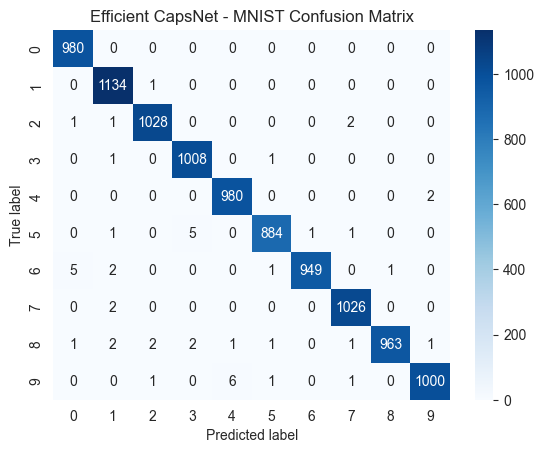

In [23]:
args = {
    "batch_size": 64,
    "test_batch_size": 64,
    "epochs": 20,
    "lr": 5e-4,
    "seed": 22,
    "log_interval": 50,
    "no_cuda": False,
    "with_reconstruction": True,
}
args["cuda"] = not args["no_cuda"] and torch.cuda.is_available()

torch.manual_seed(args["seed"])
if args["cuda"]:
    torch.cuda.manual_seed(args["seed"])

kwargs = {"num_workers": 1, "pin_memory": True} if args["cuda"] else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Pad(2), transforms.RandomCrop(28), transforms.ToTensor()]
        ),
    ),
    batch_size=args["batch_size"],
    shuffle=True,
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data",
        train=False,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=args["test_batch_size"],
    shuffle=False,
    **kwargs
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientCapsNet().to(device)

if args["with_reconstruction"]:
    reconstruction_model = ReconstructionNet(16, 10)
    reconstruction_alpha = 0.0005
    model = EfficientCapsNetWithReconstruction(model, reconstruction_model).to(
        device
    )

if args["cuda"]:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args["lr"])

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, verbose=True, factor=0.9, patience=4, min_lr=1e-5, mode="max"
)

loss_fn = MarginLoss(0.9, 0.1, 0.5)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args["cuda"]:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        if args["with_reconstruction"]:
            output, probs = model(data)
            reconstruction_loss = F.mse_loss(output, data.view(-1, 784))
            margin_loss = loss_fn(probs, target)
            loss = reconstruction_alpha * reconstruction_loss + margin_loss
        else:
            output, probs = model(data)
            loss = loss_fn(probs, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args["log_interval"] == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

def test(final=False):
    global confusion_mat
    model.eval()
    test_loss = 0
    correct = 0
    if final:
        confusion_mat = np.zeros((10, 10), dtype=int)
    for data, target in test_loader:
        if args["cuda"]:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        if args["with_reconstruction"]:
            output, probs = model(data)
            reconstruction_loss = F.mse_loss(
                output, data.view(-1, 784), size_average=False
            ).item()
            test_loss += loss_fn(probs, target, size_average=False).item()
            test_loss += reconstruction_alpha * reconstruction_loss
        else:
            output, probs = model(data)
            test_loss += loss_fn(probs, target, size_average=False).item()

        pred = probs.data.max(1, keepdim=True)[
            1
        ]  # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if final:
            for i in range(len(pred)):
                true_label = target[i].item()
                pred_label = pred[i].item()
                confusion_mat[true_label][pred_label] += 1

    test_loss /= len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    if final:
        sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title("Efficient CapsNet - MNIST Confusion Matrix")
        plt.savefig(
            "confusion_mat-reconstruction{}.png".format(args["with_reconstruction"])
        )
    return test_loss

for epoch in range(1, args["epochs"] + 1):
    final = True if epoch == args["epochs"] else False
    train(epoch)
    test_loss = test(final)
    scheduler.step(test_loss)
    if epoch % 1 == 0 or epoch == args["epochs"]:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": test_loss,
            },
            os.path.join(
                "./checkpoints",
                "{:03d}_model_dict_reconstruction{}.pth".format(
                    epoch, args["with_reconstruction"]
                ),
            ),
        )

print("\n", "-" * 28, "Finished Training", "-" * 28, "\n")
if not args["with_reconstruction"]:
    summary(model, input_size=(1, 28, 28))